This notebook analyses our results for the success probability and median running time of QAOA for $k$-NAE-SAT.

In [248]:
import os
import torch
import h5py
import sys
import json
import matplotlib.pyplot as plt
import numpy as np

nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
parent_dir = os.path.dirname(os.getcwd())

In [249]:
# Parameters
ps = [1,2,4,8,16,20,24,30,35,40]
ks = [i for i in range(3, 11)]
ns = [i for i in range(12, 21)]
num_proc = 10
batch_size = 250
psuccs = {k : {n : {p : 0 for p in ps} for n in ns} for k in ks}
rts = {k : {n : {p : torch.zeros(size=(num_proc * batch_size, )) for p in ps} for n in ns} for k in ks}

We begin with success probability

In [250]:
# Extract p=1,2,4
ps = [1,2,4]
dir = f"{parent_dir}/experiments/knaesat_eval/p_1-4"
for k in ks:
	for n in ns:
		for proc in range(num_proc):
			index = proc * batch_size
			filename = f'{dir}/p_succ_{n}_{k}_{index}.json' 
			with open(filename, 'r') as f:
				data = json.load(f)
			for p in ps:
				psuccs[k][n][p] += data[str(n)][str(p)] / (batch_size * num_proc)

In [ ]:
for k in ks:
	for n in ns:
		for p in ps:
			for proc in range(num_proc):
				index = proc * batch_size
				filename = f'p_succ_{n}_{k}_{p}_{index}.json' 
				with open(filename, 'r') as f:
					data = json.load(f)
					psuccs[k][n][p] += data[str(n)][str(p)] / (batch_size * num_proc)

In [251]:
# Extract p=8,16,20,24,30
ps=[8,16,20,24,30]
ns = [i for i in range(12, 20)]
dir = f"{parent_dir}/experiments/knaesat_eval/p_8-30"
for k in ks:
	for n in ns:
		for proc in range(num_proc):
			index = proc * batch_size
			filename = f'{dir}/p_succ_{n}_{k}_{index}.json' 
			with open(filename, 'r') as f:
				data = json.load(f)
			for p in ps:
				if p == 30:
					filename = f'{dir}/p_succ_{n}_{k}_{30}_{index}.json' 
					with open(filename, 'r') as f:
						data = json.load(f)
						psuccs[k][n][30] += data[str(n)][str(30)] / (batch_size * num_proc)
				else:
					psuccs[k][n][p] += data[str(n)][str(p)] / (batch_size * num_proc)

In [252]:
# Extract p=35,40
num_proc = 50
batch_size = 50
ps=[35, 40]
ns = [i for i in range(12, 20)]
dir = f"{parent_dir}/experiments/knaesat_eval/p_35-40"
for k in ks:
	for n in ns:
		for p in ps:
			count = 0
			for proc in range(num_proc):
				index = proc * batch_size
				filename = f'{dir}/p_succ_{n}_{k}_{p}_{index}.json' 
				try:
					with open(filename, 'r') as f:
						data = json.load(f)
						psuccs[k][n][p] += data[str(n)][str(p)]
						count +=1
				except:
					pass
			psuccs[k][n][p] = psuccs[k][n][p] / (batch_size * count)

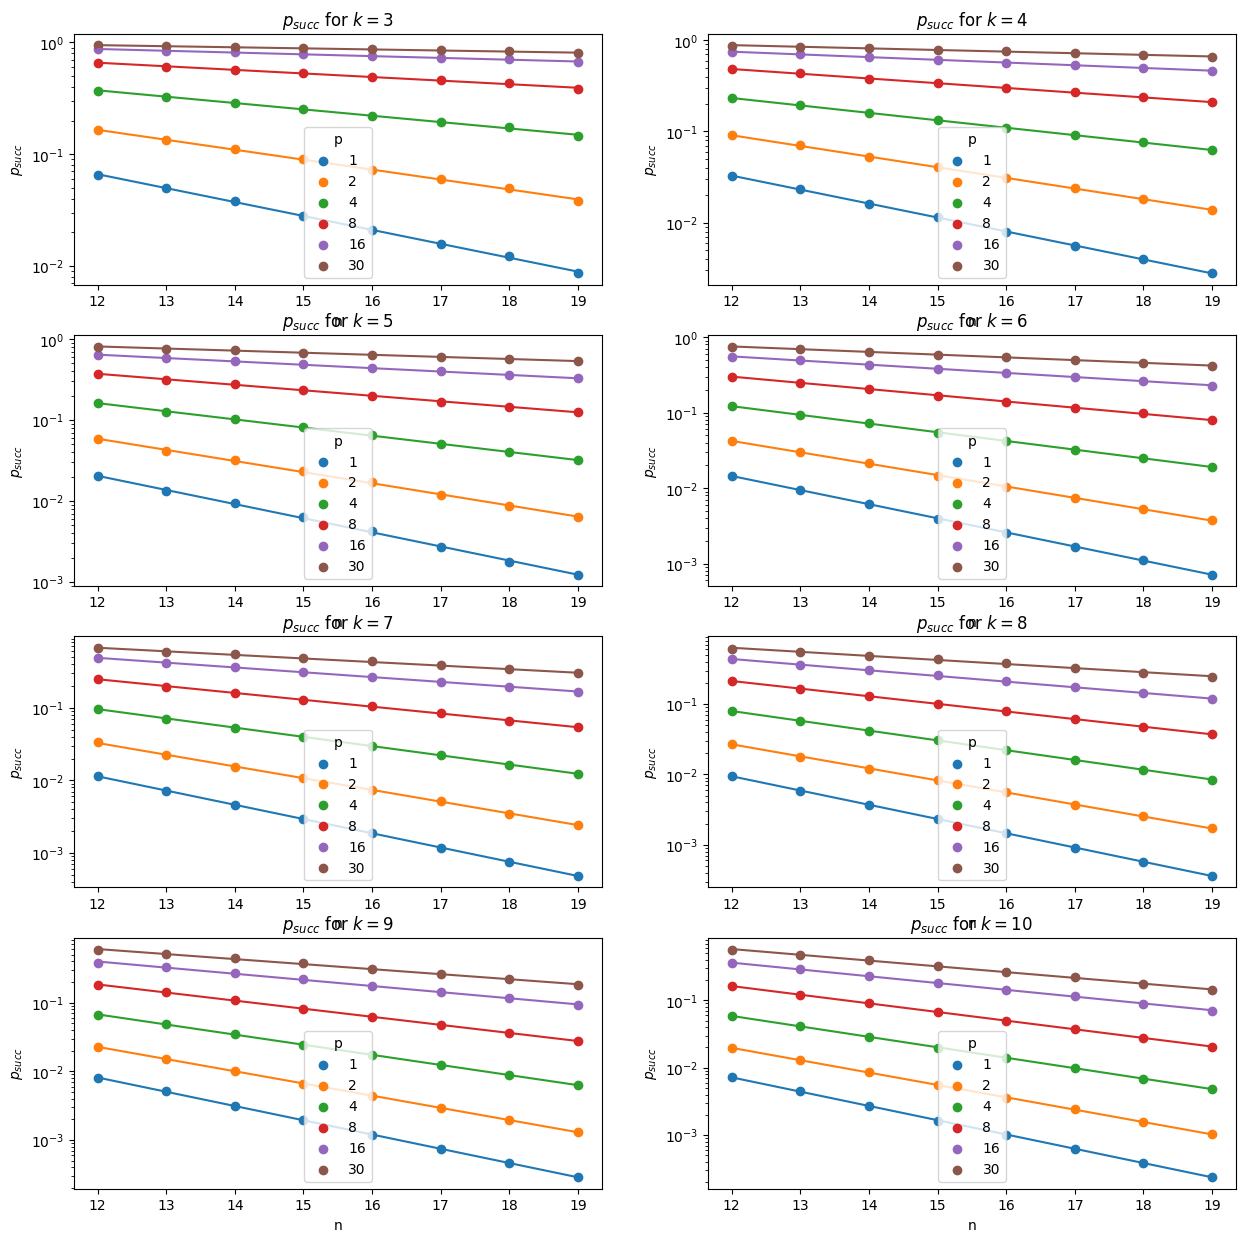

In [253]:
# Plot
ps = [1,2,4,8,16,30]
ns = [i for i in range(12, 20)]
fig, axs = plt.subplots(len(ks) // 2, 2, figsize=(15, 15))
for (ax, k) in zip(axs.flatten(), ks):
	psucck = [[psuccs[k][n][p] for n in ns] for p in ps]

	for (p, psucc) in zip(ps, psucck):

		# Points
		ax.scatter(ns, psucc, label=p)

		# Line of best fit
		coefficients = np.polyfit(ns, np.log2(psucc), 1)
		polynomial = np.poly1d(coefficients)
		ax.plot(ns, 2**(polynomial(ns)))

	ax.set_yscale('log')
	ax.set_xlabel('n')
	ax.set_ylabel('$p_{succ}$')
	ax.legend(title='p')
	ax.set_title('$p_{succ}$'+ f' for $k = {k}$')


<Figure size 1500x1000 with 0 Axes>

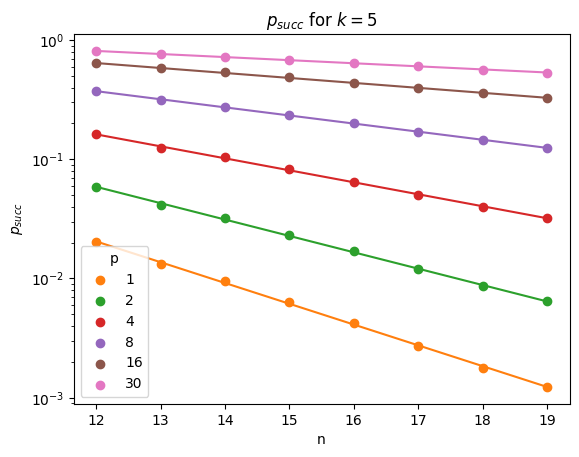

<Figure size 1500x1000 with 0 Axes>

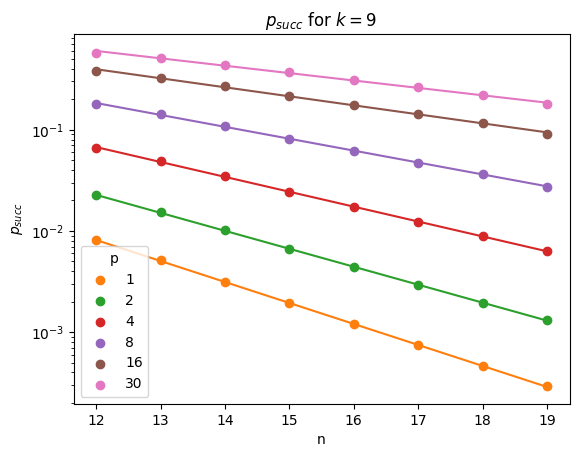

In [257]:
# Plots particularly for k=5,9

colormap = plt.cm.get_cmap('tab10')
colors = [colormap(i+1) for i in range(len(ps))]

for k in [5,9]:
    plt.figure(figsize=(15, 10))
    fig, ax = plt.subplots()
    psucck = [[psuccs[k][n][p] for n in ns] for p in ps]
    
    for (p, psucc, color) in zip(ps, psucck, colors):
        # Points
        ax.scatter(ns, psucc, label=p, color=color)

        # Line of best fit
        coefficients = np.polyfit(x=ns, y=np.log2(psucc), deg=1)
        polynomial = np.poly1d(coefficients)
        ax.plot(ns, np.exp2(polynomial(ns)), color=color)

    ax.set_yscale('log')
    ax.set_xlabel('n')
    ax.set_ylabel('$p_{succ}$')
    ax.legend(title='p')
    ax.set_title('$p_{succ}$' + f' for $k = {k}$')

Next, we analyse and plot median running times

In [223]:
# Extract p=1,2,4
num_proc = 10
batch_size = 250
ps = [1,2,4]
dir = f'{parent_dir}/experiments/knaesat_eval/p_1-4'
mrts = {k : {n : {p : 0 for p in ps} for n in ns} for k in ks}
for k in ks:
	for n in ns:
		for p in ps:
			print(f'{k},{n},{p}')
			curr = torch.zeros(size=(num_proc * batch_size, ))
			for proc in range(num_proc):
				filename = f'rt_{n}_{k}_{p}_{proc * batch_size}.hdf5' 
				with h5py.File(filename, 'r') as file:
					fresh = torch.from_numpy(file.get('times')[:])
					index = proc * batch_size
					curr[index : index + batch_size] = fresh
			mrts[k][n][p] = torch.median(curr)

In [224]:
# Extract p=8,16,20,24,30
ps=[8,16,20,24,30]
ns = [i for i in range(12, 20)]
dir = f"{parent_dir}/experiments/knaesat_eval/p_8-30"
for k in ks:
	for n in ns:
		for proc in range(num_proc):
			for p in ps:
				filename = f'{dir}/rt_{n}_{k}_{p}_{proc * batch_size}.hdf5' 
				with h5py.File(filename, 'r') as file:
					fresh = torch.from_numpy(file.get('times')[:])
					index = proc * batch_size
					rts[k][n][p][index : index + batch_size] = fresh

In [225]:
# Extract p=35,40
num_proc = 50
batch_size = 50
ps=[35, 40]
ns = [i for i in range(12, 20)]
dir = f"{parent_dir}/experiments/knaesat_eval/p_35-40"
for k in ks:
	for n in ns:
		for proc in range(num_proc):
			for p in ps:
				filename = f'{dir}/rt_{n}_{k}_{p}_{proc * batch_size}.hdf5' 
				try:
					with h5py.File(filename, 'r') as file:
						fresh = torch.from_numpy(file.get('times')[:])
						index = proc * batch_size
						rts[k][n][p][index : index + batch_size] = fresh
				except:
					pass

In [226]:
# Combine (find median)
ps = [1,2,4,8,16,20,24,30,35,40]
mrts = {k : {n : {p : torch.median(rts[k][n][p]) for p in ps} for n in ns} for k in ks}

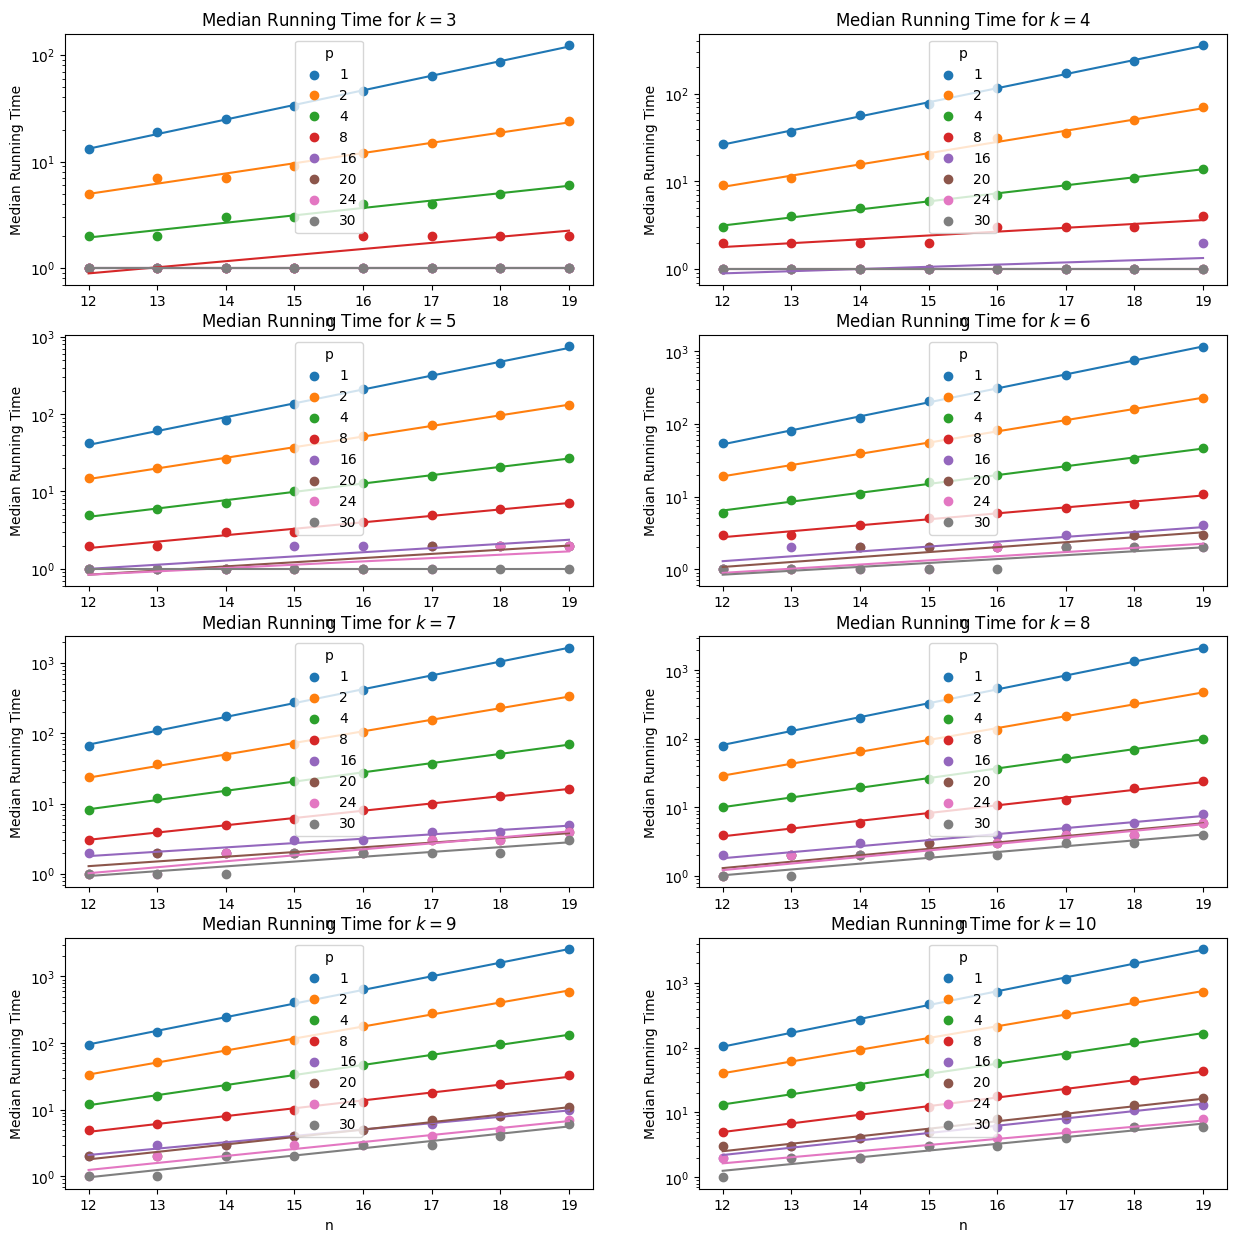

In [227]:
# Plot
ps = [1,2,4,8,16,20,24,30]#,35,40]
ns = [i for i in range(12, 20)]
fig, axs = plt.subplots(len(ks) // 2, 2, figsize=(15, 15))
for (ax, k) in zip(axs.flatten(), ks):
	mrtk = [[mrts[k][n][p] for n in ns] for p in ps]

	for (p, mrt) in zip(ps, mrtk):

		# Points
		ax.scatter(ns, mrt, label=p)

		# Line of best fit
		coefficients = np.polyfit(ns, np.log2(mrt), 1)
		polynomial = np.poly1d(coefficients)
		ax.plot(ns, 2**(polynomial(ns)))

	ax.set_yscale('log')
	ax.set_xlabel('n')
	ax.set_ylabel('Median Running Time')
	ax.legend(title='p')
	ax.set_title('Median Running Time'+ f' for $k = {k}$')

We evaluate the relationship

$$p_{succ} = \frac{1}{mrt}$$

<Figure size 1500x1000 with 0 Axes>

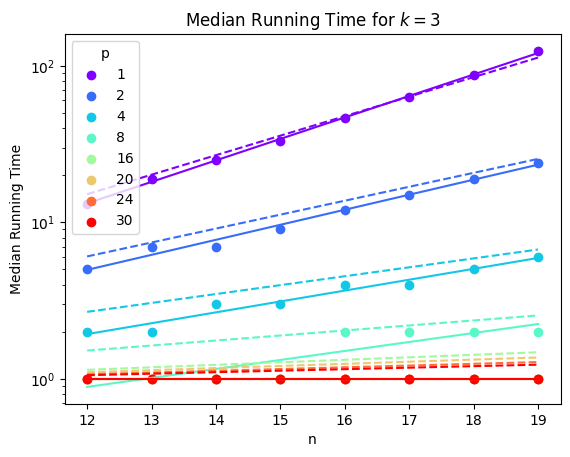

<Figure size 1500x1000 with 0 Axes>

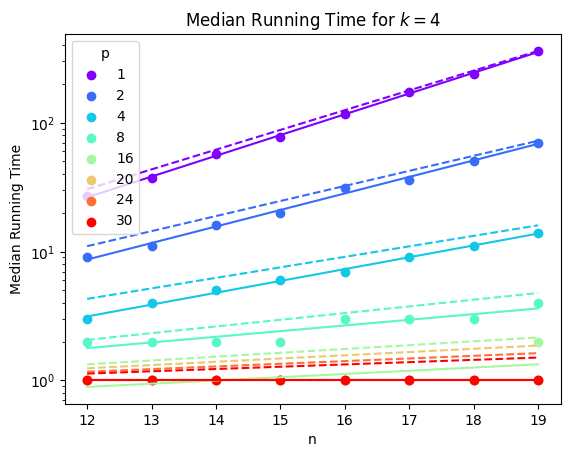

<Figure size 1500x1000 with 0 Axes>

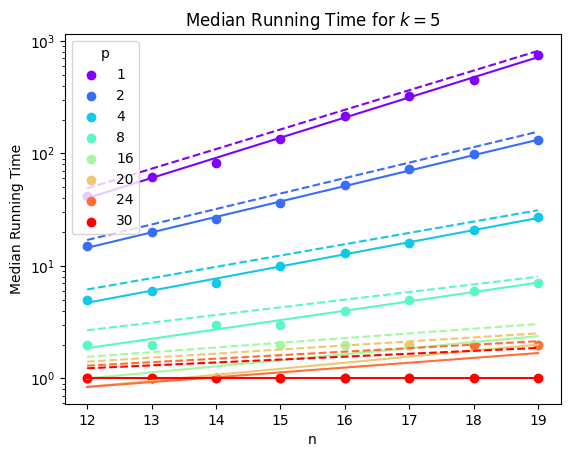

<Figure size 1500x1000 with 0 Axes>

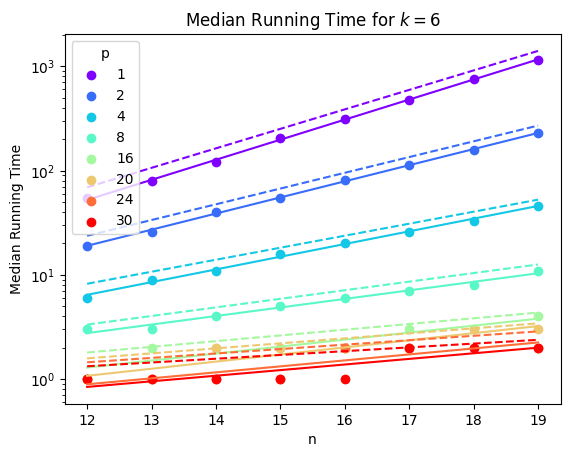

<Figure size 1500x1000 with 0 Axes>

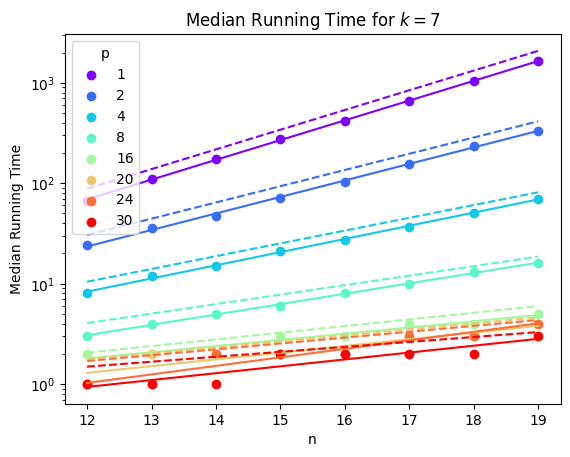

<Figure size 1500x1000 with 0 Axes>

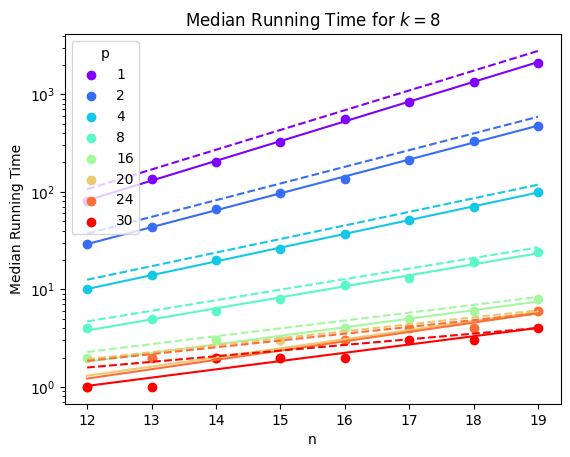

<Figure size 1500x1000 with 0 Axes>

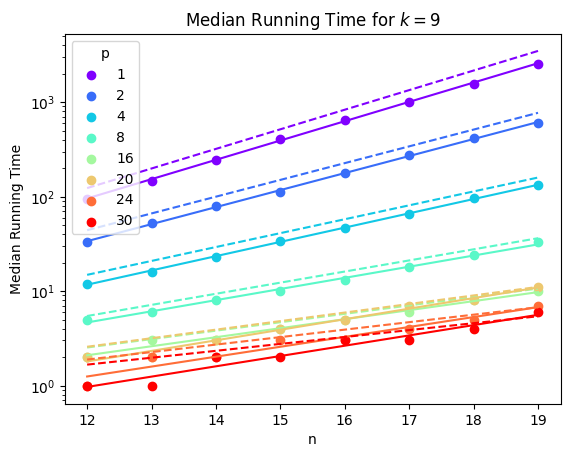

<Figure size 1500x1000 with 0 Axes>

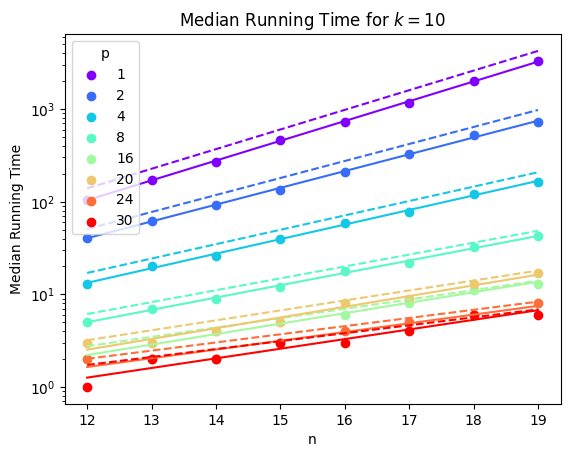

In [228]:
for k in ks:
	plt.figure(figsize=(15, 10))
	fig, ax = plt.subplots()
	mrtk = [[mrts[k][n][p] for n in ns] for p in ps]
	psucck = [[psuccs[k][n][p] for n in ns] for p in ps]
	color = iter(plt.cm.rainbow(np.linspace(0, 1, len(ps))))

	for (p, mrt, psucc) in zip(ps, mrtk, psucck):
		c = next(color)

		# mrt
		ax.scatter(ns, mrt, label=p, color=c)
		coefficients = np.polyfit(ns, np.log2(mrt), 1)
		polynomial = np.poly1d(coefficients)
		ax.plot(ns, 2**(polynomial(ns)), color=c)

		#psucc
		coefficients = np.polyfit(ns, np.log2(psucc), 1)
		polynomial = np.poly1d(-1 * coefficients)
		ax.plot(ns, 2**(polynomial(ns)), color=c, linestyle='dashed')


	ax.set_yscale('log')
	ax.set_xlabel('n')
	ax.set_ylabel('Median Running Time')
	ax.legend(title='p')
	ax.set_title('Median Running Time'+ f' for $k = {k}$')

Coefficients

In [229]:
# Calculate coeffs
psucc_coeffs = {k : {p : {} for p in ps} for k in ks}
mrt_coeffs = {k : {p : {} for p in ps} for k in ks}

for k in ks:
	mrtk = [[mrts[k][n][p] for n in ns] for p in ps]
	psucck = [[psuccs[k][n][p] for n in ns] for p in ps]
	for (p, mrtk, psucc) in zip(ps, mrtk, psucck):
		# mrt
		coefficients = np.polyfit(ns, np.log2(mrtk), 1)
		mrt_coeffs[k][p]['c'] = list(coefficients)
		#psucc
		coefficients = np.polyfit(ns, np.log2(psucc), 1)
		psucc_coeffs[k][p]['c'] = list(coefficients)

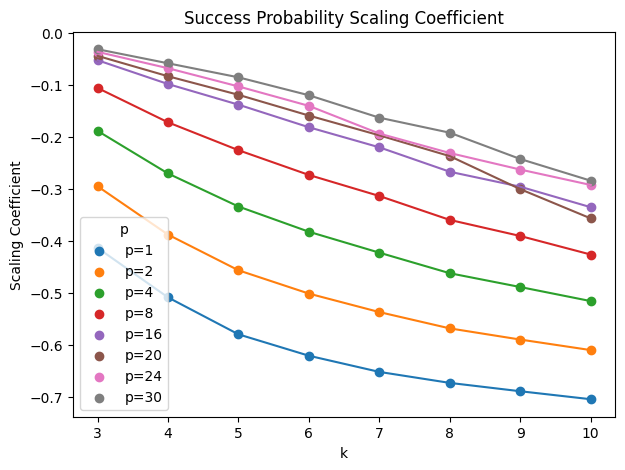

In [232]:
# Plot psucc coefficients as a function of p
fig, ax = plt.subplots(figsize=(7, 5))
for p in ps:
    coefficients = [psucc_coeffs[k][p]['c'][0] for k in ks]
    ax.scatter(ks, coefficients, label=f"p={p}")
    ax.plot(ks, coefficients)
ax.set_xlabel("k")
ax.set_ylabel("Scaling Coefficient")
ax.legend(title="p")
ax.set_title("Success Probability Scaling Coefficient")
plt.show()

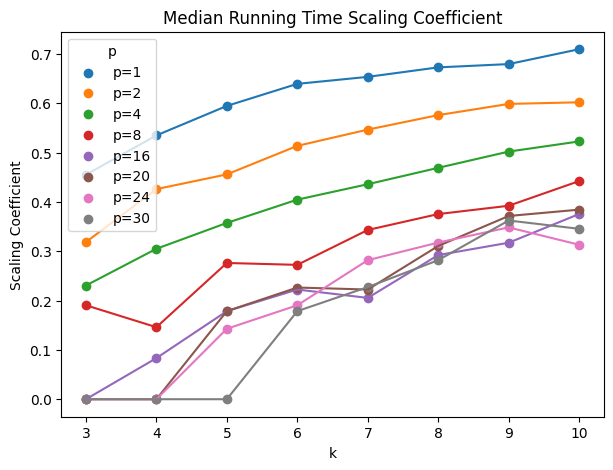

In [233]:
# Plot mrt coefficients as a function of p
fig, ax = plt.subplots(figsize=(7, 5))
for p in ps:
    coefficients = [mrt_coeffs[k][p]['c'][0] for k in ks]
    ax.scatter(ks, coefficients, label=f"p={p}")
    ax.plot(ks, coefficients)
ax.set_xlabel("k")
ax.set_ylabel("Scaling Coefficient")
ax.legend(title="p")
ax.set_title("Median Running Time Scaling Coefficient")
plt.show()

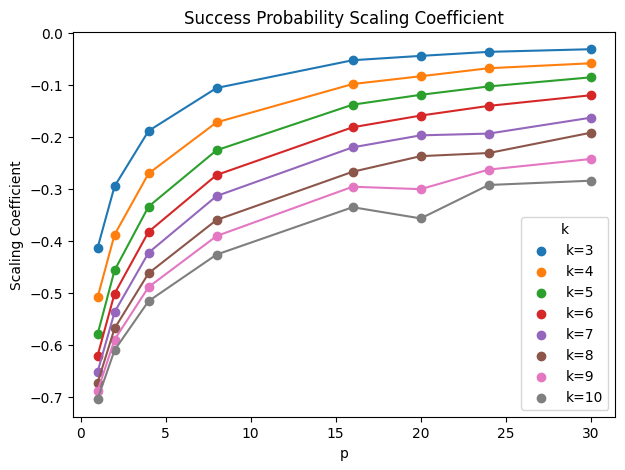

In [234]:
# Plot psucc coefficients as a function of k
fig, ax = plt.subplots(figsize=(7, 5))
for k in ks:
    coefficients = [psucc_coeffs[k][p]['c'][0] for p in ps]
    ax.scatter(ps, coefficients, label=f"k={k}")
    ax.plot(ps, coefficients)
ax.set_xlabel("p")
ax.set_ylabel("Scaling Coefficient")
ax.legend(title="k")
ax.set_title("Success Probability Scaling Coefficient")
plt.show()

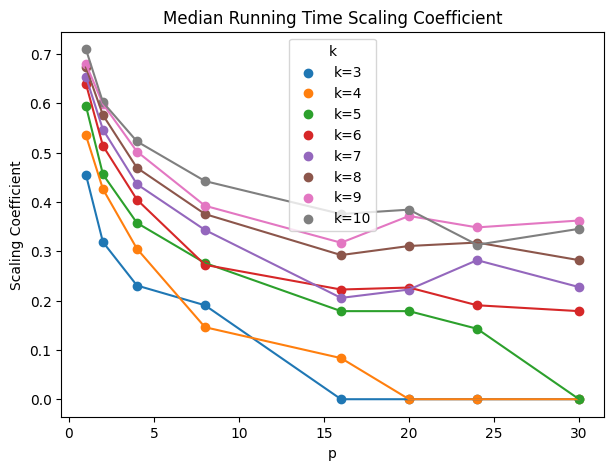

In [235]:
# Plot mrt coefficients as a function of k
fig, ax = plt.subplots(figsize=(7, 5))
for k in ks:
    coefficients = [mrt_coeffs[k][p]['c'][0] for p in ps]
    ax.scatter(ps, coefficients, label=f"k={k}")
    ax.plot(ps, coefficients)
ax.set_xlabel("p")
ax.set_ylabel("Scaling Coefficient")
ax.legend(title="k")
ax.set_title("Median Running Time Scaling Coefficient")
plt.show()

Next, we benchmark against `WalkSATlm`

In [236]:
# Parameters
num_proc = 10
batch_size = 250
ks = [i for i in range(3, 11)]
ns = [i for i in range(12, 21)]
tbs = ['m', 'b', 'm2', 'm2b2']

In [237]:
# Extract WalkSAT mrts
dir = f'{parent_dir}/experiments/knaesat_benchmark/walksat_eval'
ws_rts = {k : {n : {tb : torch.zeros(size=(num_proc * batch_size, )) for tb in tbs} for n in ns} for k in ks}
for k in ks:
	for n in ns:
		for proc in range(num_proc):
			for tb in tbs:
				filename = f'{dir}/rt_{n}_{k}_{tb}_{proc * batch_size}.hdf5' 
				with h5py.File(filename, 'r') as file:
					fresh = torch.from_numpy(file.get('times')[:])
					index = proc * batch_size
					ws_rts[k][n][tb][index : index + batch_size] = fresh

ws_mrts = {k : {n : {tb : torch.median(ws_rts[k][n][tb]) for tb in tbs} for n in ns} for k in ks}

<Figure size 1500x1000 with 0 Axes>

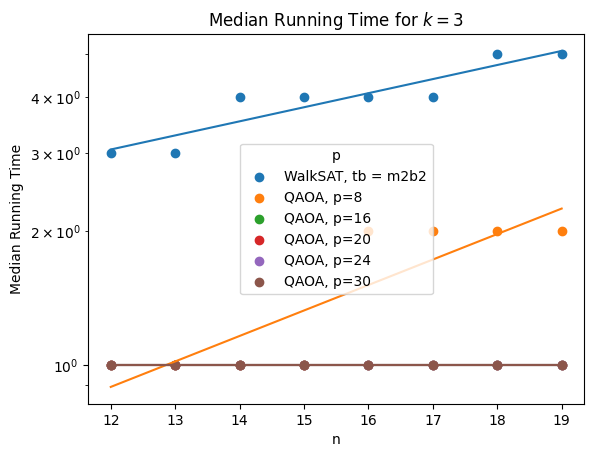

<Figure size 1500x1000 with 0 Axes>

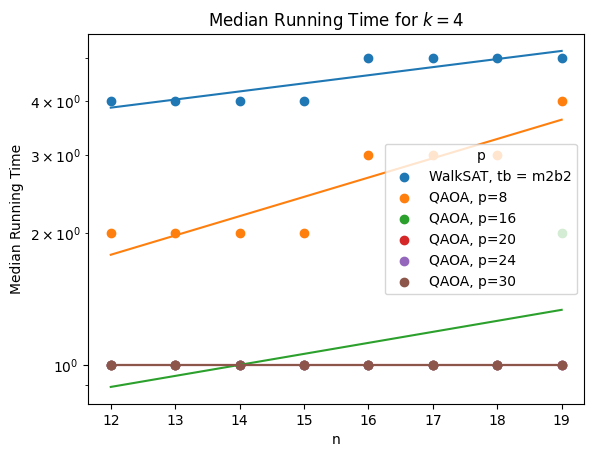

<Figure size 1500x1000 with 0 Axes>

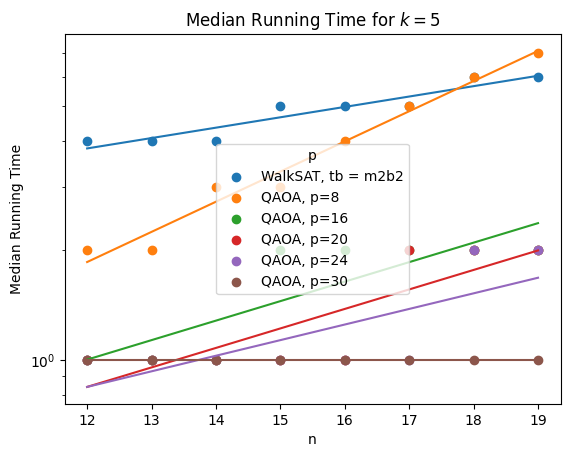

<Figure size 1500x1000 with 0 Axes>

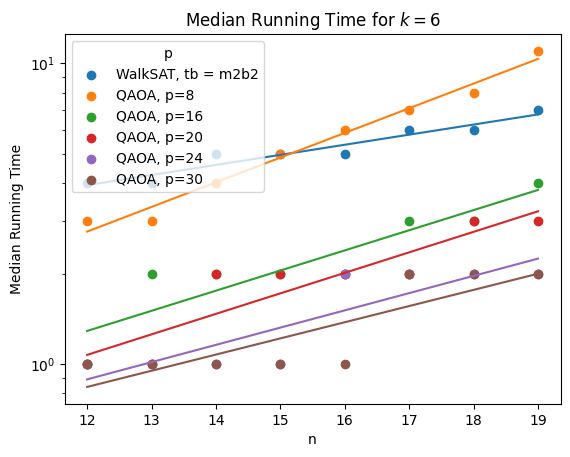

<Figure size 1500x1000 with 0 Axes>

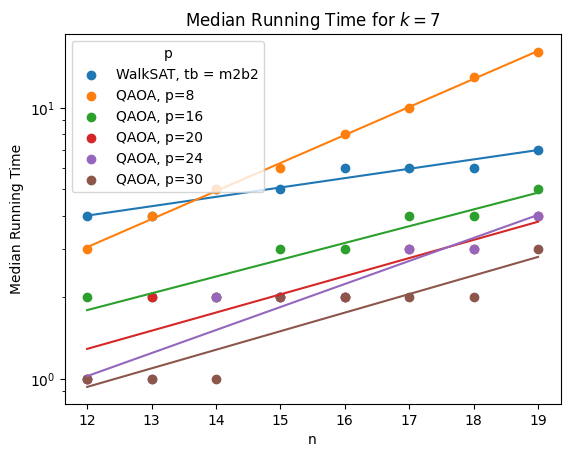

<Figure size 1500x1000 with 0 Axes>

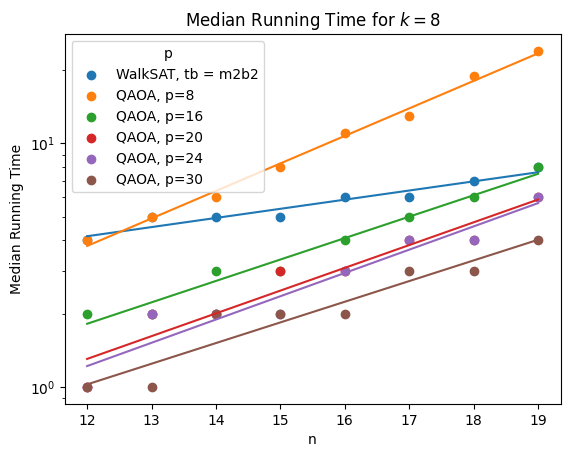

<Figure size 1500x1000 with 0 Axes>

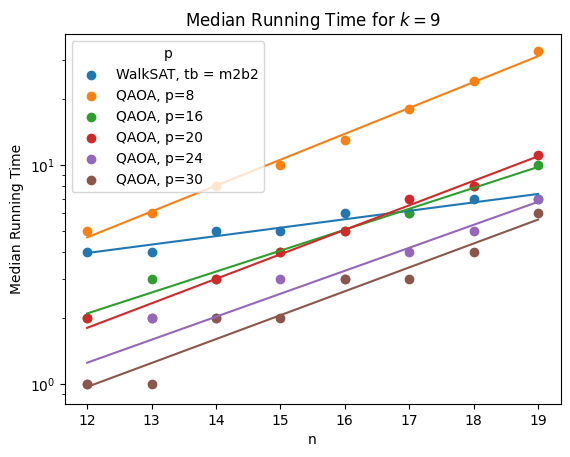

<Figure size 1500x1000 with 0 Axes>

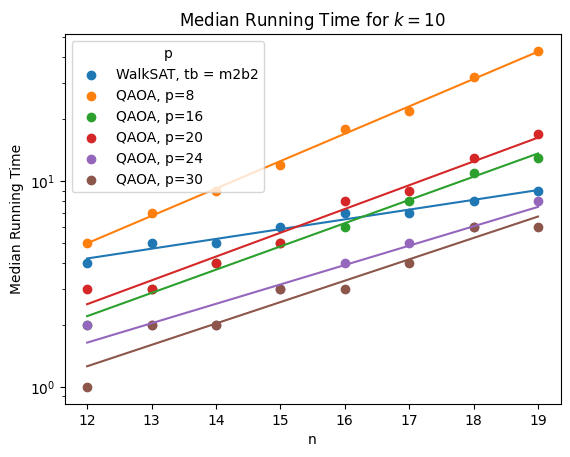

In [238]:
# Plot
ns = [i for i in range(12, 20)]
for k in ks:
	plt.figure(figsize=(15, 10))
	fig, ax = plt.subplots()

	# WalkSAT
	tbs = ['m2b2']
	ws_mrtk = [[ws_mrts[k][n][tb] for n in ns] for tb in tbs]
	for (tb, mrt) in zip(tbs, ws_mrtk):
		ax.scatter(ns, mrt, label=f'WalkSAT, tb = {tb}')
		coefficients, error = np.polyfit(ns, np.log(mrt), 1, cov=True)
		polynomial = np.poly1d(coefficients)
		ax.plot(ns, np.exp(polynomial(ns)))

	# QAOA
	ps = [8,16,20,24,30]
	mrtk = [[mrts[k][n][p] for n in ns] for p in ps]
	for (p, mrtk) in zip(ps, mrtk):
		ax.scatter(ns, mrtk, label=f'QAOA, p={p}')
		coefficients, error = np.polyfit(ns, np.log(mrtk), 1, cov=True)
		polynomial = np.poly1d(coefficients)
		ax.plot(ns, np.exp(polynomial(ns)))

	ax.set_yscale('log')
	ax.set_xlabel('n')
	ax.set_ylabel('Median Running Time')
	ax.legend(title='p')
	ax.set_title('Median Running Time'+ f' for $k = {k}$')
	plt.show()

In [240]:
# Collect WalkSAT coeffs
for k in ks:
	for tb in tbs:
		mrt_coeffs[k][tb] = {}
		ws_mrtk = [ws_mrts[k][n][tb] for n in ns]
		coefficients = np.polyfit(ns, np.log2(ws_mrtk), 1)
		mrt_coeffs[k][tb]['c'] = list(coefficients)

In [268]:
ps = [1,2,4,8,16,20,24,30]
for p in ps:
    print(f"Running time coefficient (k = 9) for p = {p}: {mrt_coeffs[7][p]['c'][0]}")
print(f"Running time coefficient (k = 9) for WalkSAT: {mrt_coeffs[7]['m2b2']['c'][0]}")

Running time coefficient (k = 9) for p = 1: 0.6535148620605469
Running time coefficient (k = 9) for p = 2: 0.5465972764151439
Running time coefficient (k = 9) for p = 4: 0.43586372761499326
Running time coefficient (k = 9) for p = 8: 0.34312498143741077
Running time coefficient (k = 9) for p = 16: 0.20539876392909462
Running time coefficient (k = 9) for p = 20: 0.22237737973531102
Running time coefficient (k = 9) for p = 24: 0.28190118925912055
Running time coefficient (k = 9) for p = 30: 0.22731830250649232
Running time coefficient (k = 9) for WalkSAT: 0.11462423631123131
